In [65]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import random
random.seed(42)

In [72]:
# pretty plots
sns.set_context('talk')
matplotlib.rcParams['font.family'] = 'arial'

### Data understanding

In [73]:
df = pd.read_csv(r"C:\Users\fernando\Downloads\mex_clean.csv")

# convert to datetime and strip seconds 
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M')
df['dropoff_datetime'] = df['dropoff_datetime'].str.slice(0, 16)
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M')

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12694 entries, 0 to 12693
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  12694 non-null  int64         
 1   vendor_id           12694 non-null  object        
 2   pickup_datetime     12694 non-null  datetime64[ns]
 3   dropoff_datetime    12694 non-null  datetime64[ns]
 4   pickup_longitude    12694 non-null  float64       
 5   pickup_latitude     12694 non-null  float64       
 6   dropoff_longitude   12694 non-null  float64       
 7   dropoff_latitude    12694 non-null  float64       
 8   store_and_fwd_flag  12694 non-null  object        
 9   trip_duration       12694 non-null  int64         
 10  dist_meters         12694 non-null  int64         
 11  wait_sec            12694 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(4), object(2)
memory usage: 1.2+ MB


None

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,México DF Taxi de Sitio,2016-09-16 07:14:00,2016-09-18 04:41:00,-99.097369,19.416874,-99.202729,19.430353,N,120449,12373,242
1,2,México DF Taxi Libre,2016-09-18 06:16:00,2016-09-18 10:11:00,-99.297148,19.322128,-99.289949,19.326538,N,14110,1700,461
2,3,México DF Taxi Libre,2016-09-18 10:11:00,2016-09-18 10:23:00,-99.289603,19.326263,-99.271874,19.328530,N,681,2848,129
3,4,México DF Taxi Libre,2016-09-18 10:23:00,2016-09-18 10:30:00,-99.271161,19.328875,-99.279900,19.326256,N,436,1409,106
4,5,México DF Taxi Libre,2016-09-18 10:44:00,2016-09-18 10:51:00,-99.282761,19.326944,-99.291705,19.322754,N,442,1567,85


In [74]:
original_data_size = df.shape[0]
# creat new feature avg_speed
df['avg_speed'] = df['dist_meters'] / df['trip_duration']  # m/sec
df['avg_speed'] = 3.6*df['avg_speed'] # km/hr
df['avg_speed'] = np.round(df['avg_speed'])

# Remove observations with missing values
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df['pickup_longitude'].between(-100, -95)  # Update longitude range as needed
mask &= df['dropoff_longitude'].between(-100, -95)  # Update longitude range as needed
mask &= df['pickup_latitude'].between(18, 20)  # Update latitude range as needed
mask &= df['dropoff_latitude'].between(18, 20)  # Update latitude range as needed
mask &= df['trip_duration'].between(30, 2*3600)
mask &= df['wait_sec'].between(0, 2*3600)
mask &= df['dist_meters'].between(100, 100*1000)
mask &= (df['trip_duration'] > df['wait_sec'])
mask &= df['avg_speed'].between(5, 90)

df = df[mask]
cleaned_data_size = df.shape[0]

print('Original dataset size:', original_data_size,
     '\nRemoving erroneous value. Cleaned dataset size:', cleaned_data_size)

Original dataset size: 12694 
Removing erroneous value. Cleaned dataset size: 9522


In [69]:
# checking if Ids are unique, 
print("Number of columns and rows and columns are {} and {} respectively.".format(df.shape[1], df.shape[0]))
if df.id.nunique() == df.shape[0]:
    print("Dataset ids are unique")
print('\n')

# check data integrity
# remove observations if trip_duration is off my more than 2 mins of pickup and dropoff timestamp 
df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 2*60]
print('Deleting', duration_difference.shape[0], 'rows with trip_duration different from pickup and dropoff times')
df = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) <= 2*60]
del df['check_trip_duration']
print('Dataset:', df.shape[0])
print('\n')


print('store_and_fwd_flag column has only 1 unique value:', df['store_and_fwd_flag'].unique())
del df['store_and_fwd_flag']
print('Removing feature: store_and_fwd_flag')

Number of columns and rows and columns are 13 and 9522 respectively.
Dataset ids are unique


Deleting 287 rows with trip_duration different from pickup and dropoff times
Dataset: 9235


store_and_fwd_flag column has only 1 unique value: ['N']
Removing feature: store_and_fwd_flag


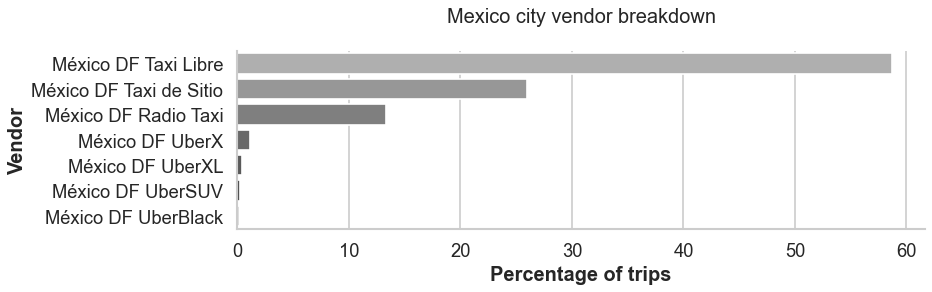

In [75]:
# since most trips are attributed to 1 vendor removing vendor id 
# replacing with boolean if vendor in Quito
vendors = pd.DataFrame(df.groupby('vendor_id')['id'].count())
vendors = vendors.reset_index()
vendors['id'] = 100*vendors['id'] / vendors['id'].sum()
vendors = vendors.sort_values('id', ascending=False)
vendors.columns = ['vendor_id', 'trips']

fig = figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 1, 1)
ax1 = sns.barplot(x="trips", y="vendor_id", data=vendors, palette=("Greys_d"))
ax1.set_xlabel('Percentage of trips', weight='bold')
ax1.set_ylabel('Vendor', weight = 'bold')
ax1.set_title('Mexico city vendor breakdown\n')

sns.despine()
plt.tight_layout();

In [76]:
print(np.round(vendors.trips[0],1),'% of trips have 1 vendor')
df['mexico'] = 1*(df['vendor_id'] == 'México DF Taxi Libre')

# deleting col 'store_and_fwd_flag'
del df['vendor_id']
print('Removing feature: vendor_id')
print('Adding feature: mexico')

13.3 % of trips have 1 vendor
Removing feature: vendor_id
Adding feature: mexico


Dataset starts from 2016-06-24 till 2017-07-20


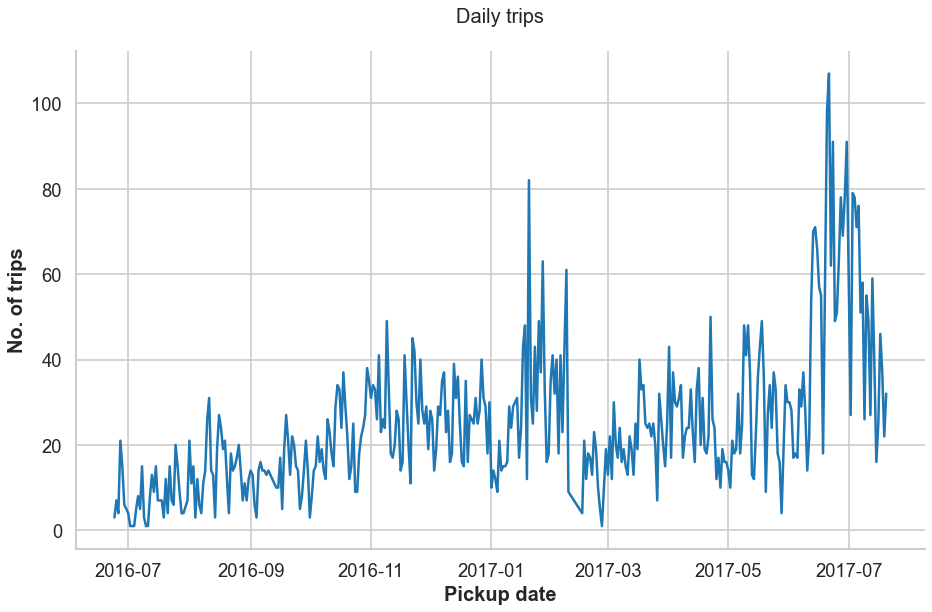

In [78]:
# Whats the daily number of trips?
df['pick_date'] = df['pickup_datetime'].dt.date
df['pick_date'] = pd.to_datetime(df['pick_date'])

pickups = pd.DataFrame(df.groupby(['pick_date'])['id'].count())
pickups = pickups.reset_index()
pickups = pickups.sort_values('pick_date', ascending=True)

# inital data is very sparse - remove sparse dates
start_date = pickups[pickups.id >1]['pick_date'].min()
end_date = pickups[pickups.id >1]['pick_date'].max()
#cutoff_date = pd.to_datetime('2017-06-30').date()

print('Dataset starts from', start_date.date(),'till', end_date.date())

# lets start from '2016-06-22' where we have more than 1 daily trip
pickups = pickups[pickups.pick_date >= start_date]

fig = figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 1, 1)
ax1 = sns.lineplot(x="pick_date", y="id", data=pickups)
ax1.set_ylabel('No. of trips', weight = 'bold')
ax1.set_xlabel('Pickup date', weight = 'bold')
ax1.set_title('Daily trips\n')
handles, labels = ax1.get_legend_handles_labels()

sns.despine()
plt.tight_layout();

In [79]:
# quantiles of wait_sec 
# median is around 3-4 mins
np.quantile(df.wait_sec, [.05, .25, .50, .75, .95])

array([  20.  ,   89.  ,  216.  ,  483.75, 1467.  ])

### Feature engineering

In [80]:
def haversine_(lat1, lng1, lat2, lng2):
    """haversine distance: 
    great-circle distance between two points on a sphere given their longitudes and latitudes."""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """manhatten distance: 
    sum of  horizontal and vertical distances between points on a grid"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """bearing:
    horizontal angle between direction of an object and another object"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [81]:
# distance related features 
# round to nearest meter
df.loc[:,'hvsine_pick_drop'] = haversine_(df['pickup_latitude'].values, 
                                                df['pickup_longitude'].values, 
                                                df['dropoff_latitude'].values, 
                                                df['dropoff_longitude'].values)
df.loc[:,'hvsine_pick_drop'] = np.round(df.loc[:,'hvsine_pick_drop'], 3)
df.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(df['pickup_latitude'].values, 
                                                           df['pickup_longitude'].values, 
                                                           df['dropoff_latitude'].values, 
                                                           df['dropoff_longitude'].values)
df.loc[:,'manhtn_pick_drop'] = np.round(df.loc[:,'manhtn_pick_drop'], 3)
# direction of travel
df.loc[:,'bearing'] = bearing_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)

In [82]:
# different speed based on distance measures
# 1 m/s = 3.6 km/hr 
df.loc[:, 'avg_speed_h'] = 3.6 * 1000 * df['hvsine_pick_drop'] / (df['trip_duration'])
df.loc[:, 'avg_speed_m'] = 3.6 * 1000 * df['manhtn_pick_drop'] / (df['trip_duration'])

# round 
df.loc[:, 'avg_speed_h'] = np.round(df.loc[:, 'avg_speed_h'])
df.loc[:, 'avg_speed_m'] = np.round(df.loc[:, 'avg_speed_m'])

In [83]:
## Mexico holiday list
# https://www.calendarr.com/mexico/calendario-2017/
holidays = ['2016-01-01', '2016-02-01', '2016-03-21', '2016-05-01', '2016-09-16', 
            '2016-11-02', '2016-11-21', '2016-12-25',
            '2017-01-01', '2017-02-06', '2017-03-20', '2017-05-01', '2017-09-16', 
            '2017-11-02', '2017-11-20', '2017-12-25']
holidays = pd.to_datetime(holidays)

In [84]:
# was the day a public holiday?
df['holiday'] = 1*(df['pick_date'].isin(holidays))

In [85]:
# time related features
df.loc[:, 'pick_month'] = df['pickup_datetime'].dt.month
df.loc[:, 'hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'week_of_year'] = df['pickup_datetime'].dt.isocalendar().week
df.loc[:, 'day_of_year'] = df['pickup_datetime'].dt.dayofyear
df.loc[:, 'day_of_week'] = df['pickup_datetime'].dt.dayofweek


In [86]:
# transforming continuous features
df['trip_duration_log'] = np.round(np.log1p(df['trip_duration']), 5)
df['dist_meters_log'] = np.round(np.log1p(df['dist_meters']), 5)
df['hvsine_pick_drop_log'] = np.round(np.log1p(df['hvsine_pick_drop']), 5)
df['manhtn_pick_drop_log'] = np.round(np.log1p(df['manhtn_pick_drop']), 5)

In [87]:
display(df.shape[1])
display(df.columns)

29

Index(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'dist_meters', 'wait_sec',
       'avg_speed', 'mexico', 'pick_date', 'hvsine_pick_drop',
       'manhtn_pick_drop', 'bearing', 'avg_speed_h', 'avg_speed_m', 'holiday',
       'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week',
       'trip_duration_log', 'dist_meters_log', 'hvsine_pick_drop_log',
       'manhtn_pick_drop_log'],
      dtype='object')

In [88]:
# in past runs coordinates had very high feature importance  
# and training error was 3 times lower than test error
# ie- model is memorising
# binning it to 4 decimals (neighbourhood) from 6
df['pickup_longitude'] = np.round(df['pickup_longitude'], 4)
df['pickup_latitude'] = np.round(df['pickup_latitude'], 4)
df['dropoff_longitude'] = np.round(df['dropoff_longitude'], 4)
df['dropoff_latitude'] = np.round(df['dropoff_latitude'], 4)

In [91]:
from sklearn.model_selection import train_test_split
# final feature list
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
        'trip_duration', 'dist_meters', 'avg_speed', 'mexico', 
        'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing',
        'avg_speed_h', 'avg_speed_m', 'holiday', 'pick_month', 'hour',
        'week_of_year', 'day_of_year', 'day_of_week', 'trip_duration_log',
        'dist_meters_log', 'hvsine_pick_drop_log', 'manhtn_pick_drop_log', 'pick_date']
X = df[cols].copy()
y = np.log1p(df['wait_sec'].copy())

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

print('Dataset size\nTraining:', X_train.shape[0], '\nTesting:', X_test.shape[0])

Dataset size
Training: 7617 
Testing: 1905


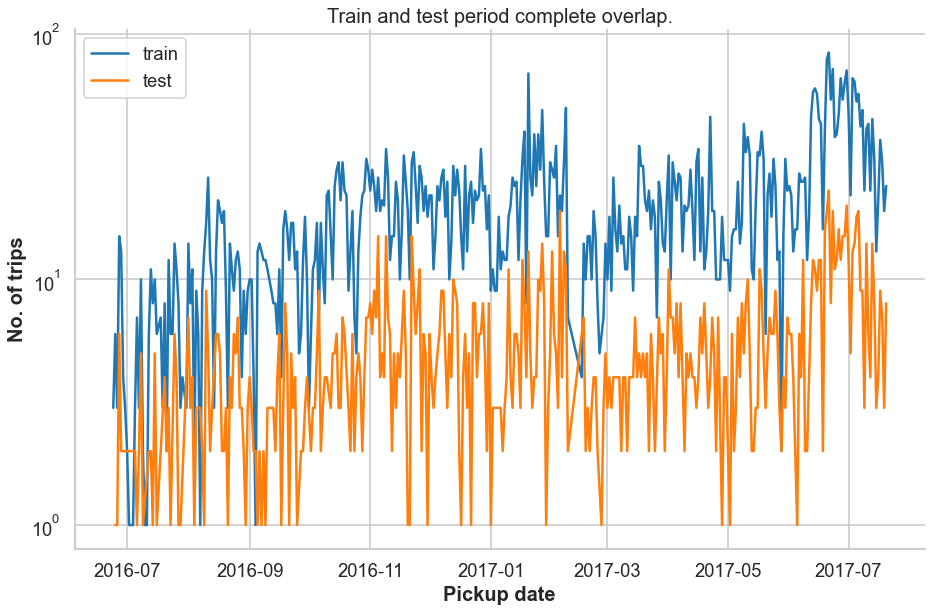

In [92]:
fig = figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(X_train.groupby('pick_date').size(), '-', label='train')
plt.plot(X_test.groupby('pick_date').size(), '-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('No. of trips', weight = 'bold')
plt.xlabel('Pickup date', weight = 'bold')
plt.yscale('log')
sns.despine()
plt.tight_layout();

del X_train['pick_date']
del X_test['pick_date']

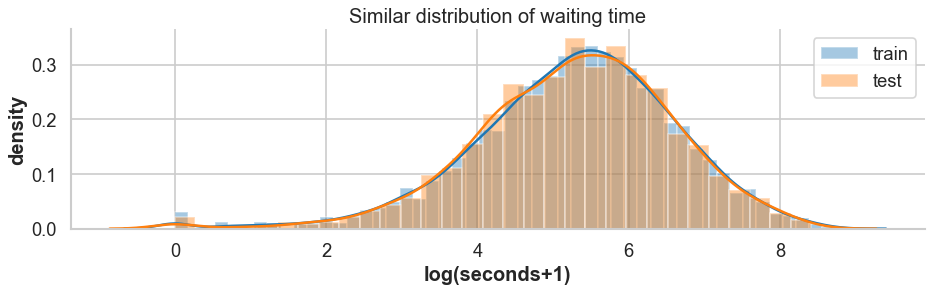

In [93]:
fig = figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

sns.distplot(y_train.values, label='train',)
             #kde_kws=dict(cumulative=True))
sns.distplot(y_test.values, label='test',)
             #kde_kws=dict(cumulative=True))
plt.title('Similar distribution of waiting time')
plt.legend(loc=0)
plt.ylabel('density', weight = 'bold')
plt.xlabel('log(seconds+1)', weight = 'bold')
sns.despine()
plt.tight_layout();

### Data Visualization

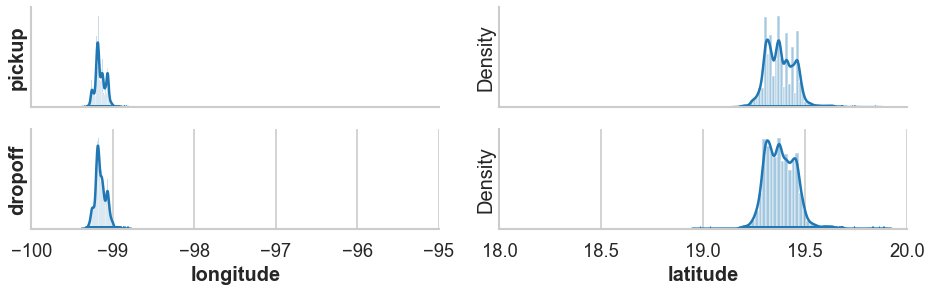

In [99]:
fig = figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
ax1 = sns.distplot(X_train.pickup_longitude, rug=True, kde=True) 
ax1.set_xlim([-100, -95])
ax1.set_ylabel('pickup', weight = 'bold')
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_xticks([])

plt.subplot(2, 2, 2)
ax2 = sns.distplot(X_train.pickup_latitude, rug=True, kde=True) 
ax2.set_xlim([18, 20])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_xticks([]) 

plt.subplot(2, 2, 3)
ax3 = sns.distplot(X_train.dropoff_longitude, rug=True, kde=True) 
ax3.set_xlim([-100, -95])
ax3.set_ylabel('dropoff', weight = 'bold')
ax3.set_xlabel('longitude', weight = 'bold')
ax3.set_yticks([])

plt.subplot(2, 2, 4)
ax4 = sns.distplot(X_train.dropoff_latitude, rug=True, kde=True) 
ax4.set_xlim([18, 20])
ax4.set_xlabel('latitude', weight = 'bold')
ax4.set_yticks([]) 

sns.despine()
plt.tight_layout();

Pickup,Dropoff

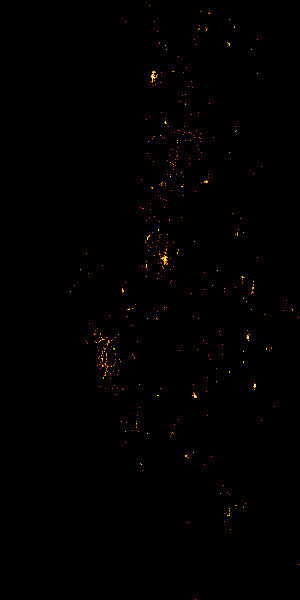
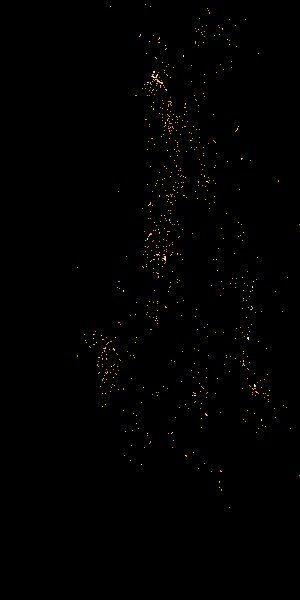

In [120]:
import datashader as ds
import datashader.transfer_functions as tf
from colorcet import fire

cvs = ds.Canvas(plot_width=2*150, plot_height=4*150,
               x_range=(-99.4,-99), y_range=(19.2,19.5))

agg = cvs.points(X_train, 'pickup_longitude', 'pickup_latitude', ds.count('trip_duration'))
pickup = tf.set_background(tf.shade(agg, cmap=fire),"black", name="Pickup")

agg = cvs.points(X_train, 'dropoff_longitude', 'dropoff_latitude', ds.count('trip_duration'))
dropoff = tf.set_background(tf.shade(agg, cmap=fire),"black", name="Dropoff")

tf.Images(pickup, dropoff)

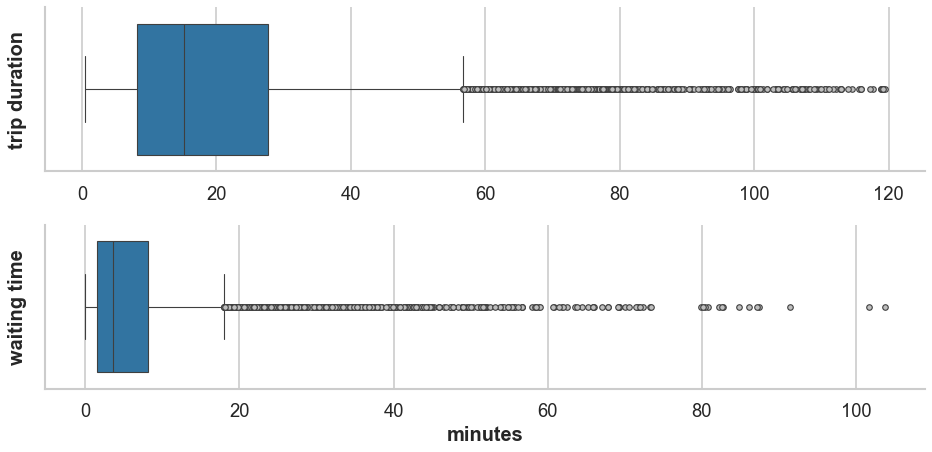

In [121]:
fig = figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')

plt.subplot(2, 1, 1)
ax1 = sns.boxplot(x=X_train['trip_duration']/60, flierprops=flierprops)
ax1.set_xlabel('', weight = 'bold')
ax1.set_ylabel('trip duration', weight = 'bold')

plt.subplot(2, 1, 2)
ax2 = sns.boxplot(x=np.expm1(y_train.values)/60, flierprops=flierprops)
ax2.set_xlabel('minutes', weight = 'bold')
ax2.set_ylabel('waiting time', weight = 'bold')

sns.despine()
plt.tight_layout();

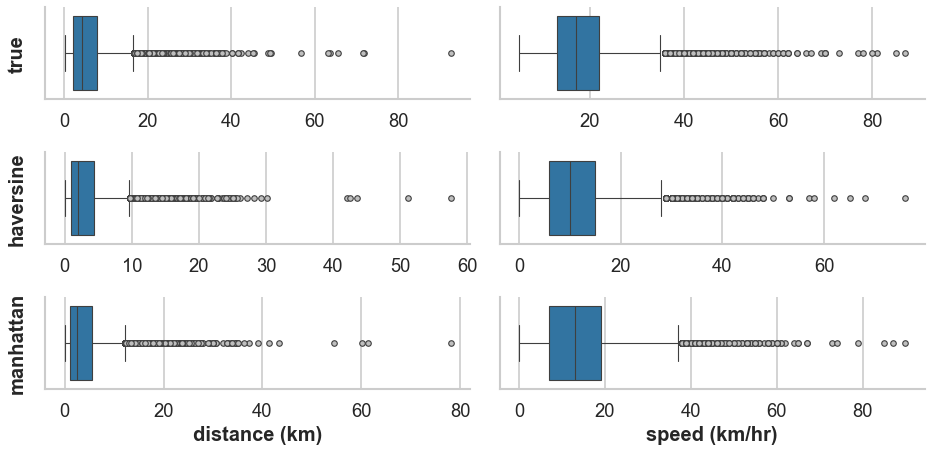

In [122]:
fig = figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')

plt.subplot(3, 2, 1)
ax1 = sns.boxplot(x=X_train['dist_meters']/1000, flierprops=flierprops)
ax1.set_ylabel('true', weight = 'bold')
ax1.set_xlabel('', weight = 'bold')

plt.subplot(3, 2, 2)
ax2 = sns.boxplot(x='avg_speed', data=X_train, flierprops=flierprops)
ax2.set_ylabel('', weight = 'bold')
ax2.set_xlabel('', weight = 'bold')

plt.subplot(3, 2, 3)
ax3 = sns.boxplot(x=X_train['hvsine_pick_drop'], flierprops=flierprops)
ax3.set_ylabel('haversine', weight = 'bold')
ax3.set_xlabel('', weight = 'bold')

plt.subplot(3, 2, 4)
ax4 = sns.boxplot(x=X_train['avg_speed_h'], flierprops=flierprops)
ax4.set_ylabel('', weight = 'bold')
ax4.set_xlabel('', weight = 'bold')

plt.subplot(3, 2, 5)
ax5 = sns.boxplot(x=X_train['manhtn_pick_drop'], flierprops=flierprops)
ax5.set_ylabel('manhattan', weight = 'bold')
ax5.set_xlabel('distance (km)', weight = 'bold')

plt.subplot(3, 2, 6)
ax6 = sns.boxplot(x='avg_speed_m', data=X_train, flierprops=flierprops)
ax6.set_ylabel('', weight = 'bold')
ax6.set_xlabel('speed (km/hr)', weight = 'bold')

sns.despine()
plt.tight_layout();

### modelling

#### Baseline linear regression

In [123]:
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
cross_val_score(reg, X_train, y_train, cv=cv)

array([0.53120893, 0.5758964 , 0.59452912, 0.5203986 ])

In [124]:
reg.fit(X_train,y_train)

LinearRegression()

In [125]:
# Predict on testing and training set
lm_y_pred = reg.predict(X_test)

# Report testing RMSE
print(np.sqrt(mean_squared_error(y_test, lm_y_pred)))

0.9031823271347963


### Bayesian Optimization with XGBoost

In [130]:
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [131]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [138]:
def xgb_evaluate(max_depth, gamma,min_child_weight,max_delta_step,subsample,colsample_bytree):
    params = {'eval_metric': 'rmse',
                  'max_depth': int(max_depth),
                  'subsample': subsample,
                  'eta': 0.1,
                  'gamma': gamma,
                  'colsample_bytree': colsample_bytree,   
                  'min_child_weight': min_child_weight ,
                  'max_delta_step':max_delta_step
                 }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
        
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [146]:
from bayes_opt.util import UtilityFunction

In [162]:
%%time
xgb_bo = BayesianOptimization(xgb_evaluate, {
    'max_depth': (2, 12),
    'gamma': (0.001, 10.0),
    'min_child_weight': (0, 20),
    'max_delta_step': (0, 10),
    'subsample': (0.4, 1.0),
    'colsample_bytree' :(0.4, 1.0)})

# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------


Exception: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported. Instead,please use the "set_gp_params" method to set
 the gp params, and pass an instance of bayes_opt.util.UtilityFunction
 using the acquisition_function argument


In [148]:
# Remove 'acq' parameter from maximize function call
xgb_bo.maximize(init_points=3, n_iter=5)

xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'max_depth': (2, 12),
        'gamma': (0.001, 10.0),
        'min_child_weight': (0, 20),
        'max_delta_step': (0, 10),
        'subsample': (0.4, 1.0),
        'colsample_bytree': (0.4, 1.0)
    }
)

# Set Gaussian process parameters using set_gp_params
xgb_bo.set_gp_params(normalize_y=True)

# Create an instance of UtilityFunction
utility = UtilityFunction(kind="ei", kappa=2.576, xi=0.0)

# Use the expected improvement acquisition function
xgb_bo.maximize(init_points=3, n_iter=5)


|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.8338   | 0.8455    | 6.12      | 4.663     | 6.68      | 17.7      | 0.4485    |
| 2         | -0.8296   | 0.5417    | 1.137     | 2.275     | 3.457     | 8.492     | 0.7808    |
| 3         | -0.8255   | 0.8563    | 1.251     | 1.77      | 8.363     | 16.08     | 0.6603    |
| 4         | -0.8483   | 0.4594    | 7.682     | 0.5686    | 3.123     | 15.35     | 0.949     |
| 5         | -0.8282   | 0.769     | 2.137     | 8.748     | 7.593     | 18.74     | 0.9713    |
| 6         | -0.8225   | 0.8267    | 0.03755   | 9.968     | 4.445     | 12.48     | 0.8528    |
| 7         | -0.8318   | 1.0       | 0.001     | 7.189     | 9.73      | 11.81     | 0.4077    |
| 8         | -0.8359   | 0.5576    | 0.001     | 9.772     | 3.346     | 15.79     | 1.0       |
| 9         | -0.823

#### Extract the parameters of the best model.

In [150]:
params = xgb_bo.max['params']
print(params)

{'colsample_bytree': 1.0, 'gamma': 0.001, 'max_delta_step': 1.7961255813622579, 'max_depth': 7.081635296583327, 'min_child_weight': 12.869374943289932, 'subsample': 0.995271391687462}


In [151]:
params['max_depth'] = int(params['max_depth'])

In [153]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=250)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

In [154]:
# Report testing and training RMSE
print('Test error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Train error:', np.sqrt(mean_squared_error(y_train, y_train_pred)))

# lm 0.6795364412436091
# better than lm 

Test error: 0.8417533326848823
Train error: 0.14828597012869085


### Evaluation of results

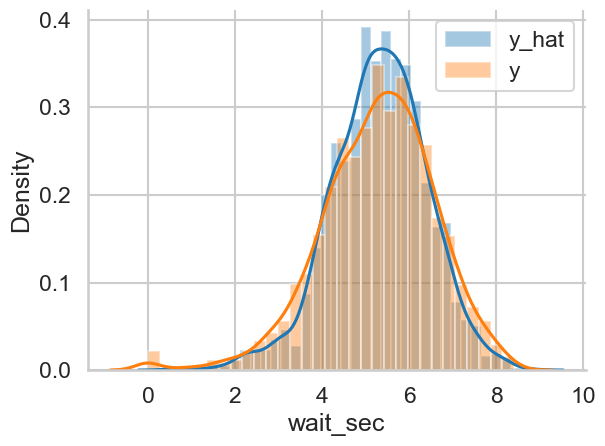

In [155]:
sns.distplot(y_pred, label='y_hat')
sns.distplot(y_test, label='y')
plt.legend()
sns.despine()
plt.tight_layout();

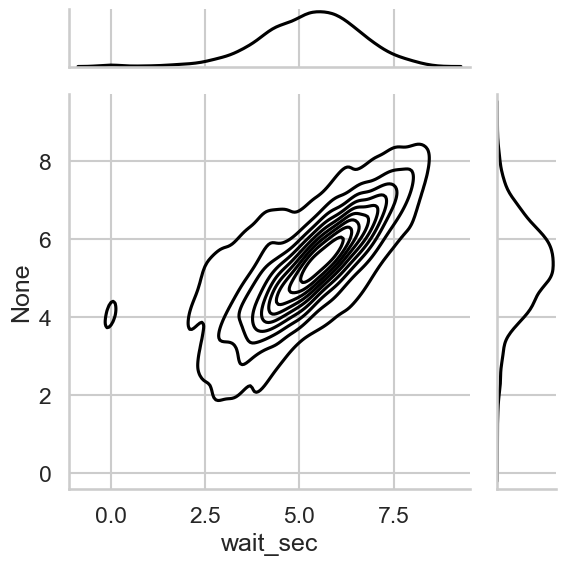

In [157]:
# actual vs predicted 
sns.jointplot(x=y_test, y=y_pred, color="k", space=0, kind='kde')
sns.despine()
plt.tight_layout();

In [158]:
wait_sec_train = np.expm1(y_train).round()
np.quantile(wait_sec_train, [0, 0.05, 0.5, 0.95, 0.99])

array([   0.  ,   20.  ,  216.  , 1472.6 , 3012.76])

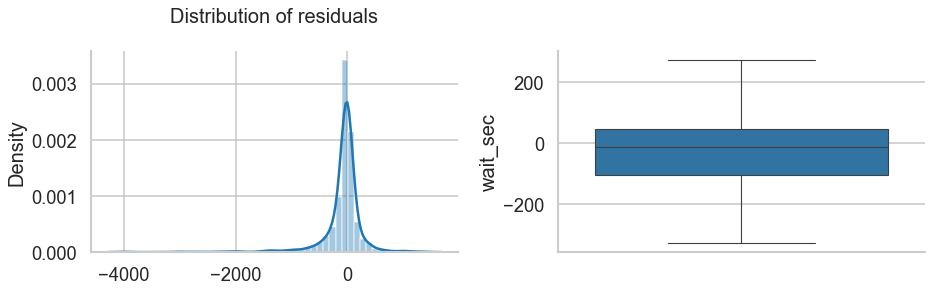

In [159]:
wait_sec_true = np.expm1(y_test).round()
wait_sec_predicted = np.expm1(y_pred).round()
# clip very high values
wait_sec_predicted = np.clip(wait_sec_predicted, 0, np.quantile(wait_sec_train, 0.95))

residual = wait_sec_predicted - wait_sec_true

fig = figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
ax1 = sns.distplot(residual)
ax1.set_title('Distribution of residuals\n')
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(residual, showfliers=False)
ax2.set_xlabel('')

sns.despine()
plt.tight_layout()

In [160]:
print("Mean absolute error:", np.abs(residual).mean())
print("Median absolute error:", np.abs(residual).median())

Mean absolute error: 182.06750680517962
Median absolute error: 72.0


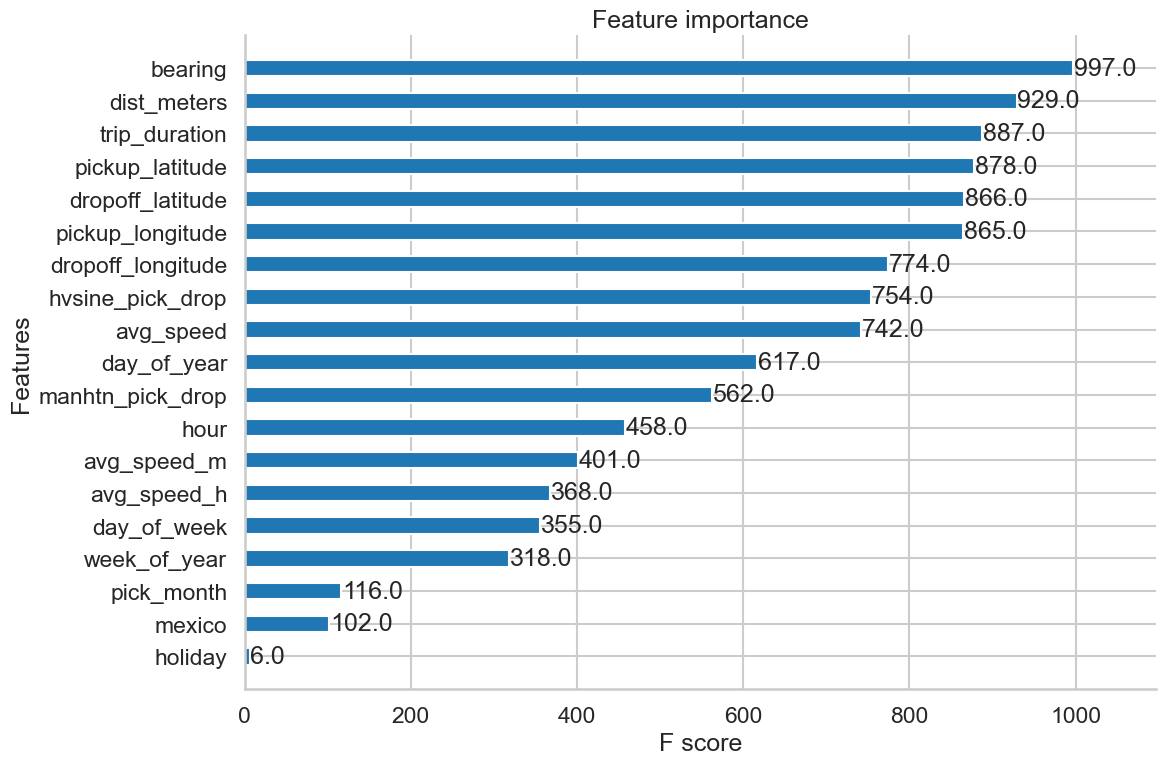

In [161]:
# feature importance
fig =  plt.figure(figsize = (12,8))
axes = fig.add_subplot(111)
xgb.plot_importance(model2,ax = axes,height =0.5)
sns.despine()
plt.tight_layout()